In [3]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from gym.spaces.box import Box
from gym.core import Wrapper
from gym.core import ObservationWrapper
from gym.spaces import Box
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2
sys.path.append('/opt/ros/kinetic/lib/python2.7/dist-packages')
from keras.layers import Conv2D, Dense, Flatten
import keras
import gym_chrome_dino
from gym_chrome_dino.utils.wrappers import make_dino
import tensorflow as tf
import tensorflow.compat.v1 as tfc
from tqdm import trange
from IPython.display import clear_output
%matplotlib inline

Using TensorFlow backend.


In [4]:
class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return (
            np.array(obses_t),
            np.array(actions),
            np.array(rewards),
            np.array(obses_tp1),
            np.array(dones)
        )

    def sample(self, batch_size):
        idxes = [
            random.randint(0, len(self._storage) - 1)
            for _ in range(batch_size)
        ]
        return self._encode_sample(idxes)

In [5]:
class FrameBuffer(Wrapper):
    
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:, :, :-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=axis)


In [6]:
class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        ObservationWrapper.__init__(self,env)        
        self.img_size = (64,64)
        self.observation_space = Box(0.0, 1.0, (self.img_size[0], self.img_size[1], 1))

    def observation(self, img): 
            
        img = img[:,:420,:]
        img = cv2.resize(img, self.img_size)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
        img=img.mean(-1,keepdims=True)
        img = img.astype('float32') / 255.
               
        return img

3
(64, 64, 1)
Box(64, 64, 1)


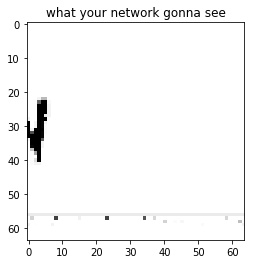

In [7]:
env = gym.make('ChromeDinoNoBrowser-v0')
env = PreprocessAtari(env)

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

obs = env.reset()
print(obs.ndim)
print(observation_shape)
print(env.observation_space)
plt.title("what your network gonna see")
plt.imshow(obs[:,:,0],interpolation='none',cmap='gray');

In [8]:
def make_env():
    env = gym.make('ChromeDinoNoBrowser-v0')
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
print(n_actions)
print(env.action_space)
print(env.get_action_meanings())
state_dim = env.observation_space.shape
print(state_dim)

2
Discrete(2)
['NOOP', 'UP', 'DOWN']
(64, 64, 4)


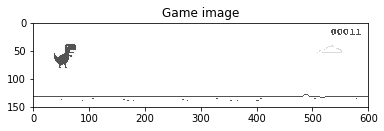

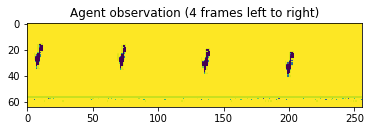

In [9]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0, 2, 1]).reshape([state_dim[0], -1]))

In [10]:
sess=tfc.InteractiveSession()
tf.compat.v1.disable_eager_execution()

In [11]:
class DQNAgent:
    def __init__(self, name, state_shape, n_actions, epsilon=0, reuse=False):
        """A simple DQN agent"""
        with tfc.variable_scope(name, reuse=reuse):

            self.network = keras.models.Sequential()
            self.network.add(Conv2D(16, (3, 3), strides=2, activation='relu', input_shape=state_shape))
            self.network.add(Conv2D(32, (3, 3), strides=2, activation='relu'))
            self.network.add(Conv2D(64, (3, 3), strides=2, activation='relu'))
            self.network.add(Flatten())
            self.network.add(Dense(256, activation='relu'))
            self.network.add(Dense(n_actions, activation='linear'))

            # prepare a graph for agent step
            self.state_t = tfc.placeholder('float32', [None, ] + list(state_shape))
            self.qvalues_t = self.get_symbolic_qvalues(self.state_t)

        self.weights = tfc.get_collection(
            tfc.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.epsilon = epsilon

    def get_symbolic_qvalues(self, state_t):
        """takes agent's observation, returns qvalues. Both are tf Tensors"""
        qvalues = self.network(state_t)
        return qvalues

    def get_qvalues(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tfc.get_default_session()
        return sess.run(self.qvalues_t, {self.state_t: state_t})

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [12]:
agent = DQNAgent("dqn_agent", state_dim, n_actions, epsilon=0.5)
sess.run(tfc.global_variables_initializer())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [15]:
evaluate(env, agent, n_games=1)
#player(env,agent,10)

0.010000000000000002

In [116]:
exp_replay = ReplayBuffer(10)
for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(), 1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

In [117]:
#count=0
#scores=[]
def play_and_record(agent, env, exp_replay, n_steps=1):
    #path = '/home/shiven/gym-chrome-dino/data2'
    s = env.framebuffer
    reward = 0.0
    for t in range(n_steps):
        
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        next_s, r, done, _ = env.step(action)
        exp_replay.add(s, action, r, next_s, done)
        reward += r
        #global count
        #count+=1
        #cv2.imwrite(os.path.join(path , str(count)+'.jpg'), env.render("rgb_array"))
        #score=env.get_score()
        #scores.append(score)
        if done:
            s = env.reset()
        else:
            s = next_s
    return reward

In [118]:
def player(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    scores=[]
    for _ in range(n_games):
        s = env.reset()
        
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                scores.append(env.get_score())
                break

        rewards.append(reward)
    print(np.mean(scores))
    return np.mean(rewards)

In [119]:
target_network = DQNAgent("target_network", state_dim, n_actions)

In [120]:
def load_weigths_into_target_network(agent, target_network):
    assigns = []
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        assigns.append(tfc.assign(w_target, w_agent, validate_shape=True))
    return assigns

In [121]:
copy_step = load_weigths_into_target_network(agent, target_network)
sess.run(copy_step)
sess.run([tfc.assert_equal(w, w_target) for w, w_target in zip(agent.weights, target_network.weights)])
print("It works!")

It works!


In [122]:
obs_ph = tfc.placeholder(tf.float32, shape=(None,) + state_dim)
actions_ph = tfc.placeholder(tf.int32, shape=[None])
rewards_ph = tfc.placeholder(tf.float32, shape=[None])
next_obs_ph = tfc.placeholder(tf.float32, shape=(None,) + state_dim)
is_done_ph = tfc.placeholder(tf.float32, shape=[None])

is_not_done = 1 - is_done_ph
gamma = 0.99

In [123]:
current_qvalues = agent.get_symbolic_qvalues(obs_ph)
current_action_qvalues = tf.reduce_sum(tf.one_hot(actions_ph, n_actions) * current_qvalues, axis=1)

In [124]:
next_qvalues_target = target_network.get_symbolic_qvalues(next_obs_ph)
next_state_values_target = tf.reduce_max(next_qvalues_target, axis=-1)
reference_qvalues = rewards_ph + gamma*next_state_values_target*is_not_done
td_loss = (current_action_qvalues - reference_qvalues) ** 2
td_loss = tf.reduce_mean(td_loss)
train_step = tfc.train.AdamOptimizer(1e-3).minimize(td_loss, var_list=agent.weights)

In [125]:
sess.run(tfc.global_variables_initializer())

In [126]:
def moving_average(x, span=100, **kw):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span, **kw).mean().values

mean_rw_history = []
td_loss_history = []

In [127]:
exp_replay = ReplayBuffer(10**2)
play_and_record(agent, env, exp_replay, n_steps=10)
def sample_batch(exp_replay, batch_size):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    return {
        obs_ph: obs_batch,
        actions_ph: act_batch,
        rewards_ph: reward_batch,
        next_obs_ph: next_obs_batch,
        is_done_ph: is_done_batch,
    }

buffer size = 100, epsilon = 0.49500


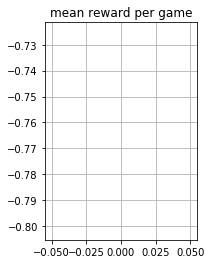

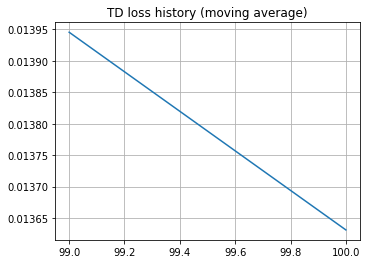

100%|██████████| 200/200 [01:48<00:00,  1.84it/s]
We finish building the model


In [128]:
for i in trange(10**2*2):
    # play
    play_and_record(agent, env, exp_replay, 10)

    # train
    _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=64))
    td_loss_history.append(loss_t)

    # adjust agent parameters
    if i % 500 == 0:
        sess.run(copy_step)
        agent.epsilon = max(agent.epsilon * 0.99, 0.01)
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3))

    if i % 100 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))

        plt.subplot(1, 2, 1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_t)
        plt.figure(figsize=[12, 4])
        plt.subplot(1, 2, 2)
        plt.title("TD loss history (moving average)")
        plt.plot(moving_average(np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()
        plt.show()
agent.network.save_weights('model.h5')
print("We finish building the model")

In [129]:
print(np.mean(mean_rw_history[-10:])) 

-0.7633333333333331


In [130]:
player(env,agent,10)

55.7


-0.7582999999999998